In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('restturantvisits.csv', names=['value'], header=0)

In [3]:
df.head()

,value
0,88
1,84
2,85
3,85
4,84


In [4]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.464240
p-value: 0.124419


In [5]:
#p value > 0.05, timeseries is non stationary, we need to make the data stationary

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

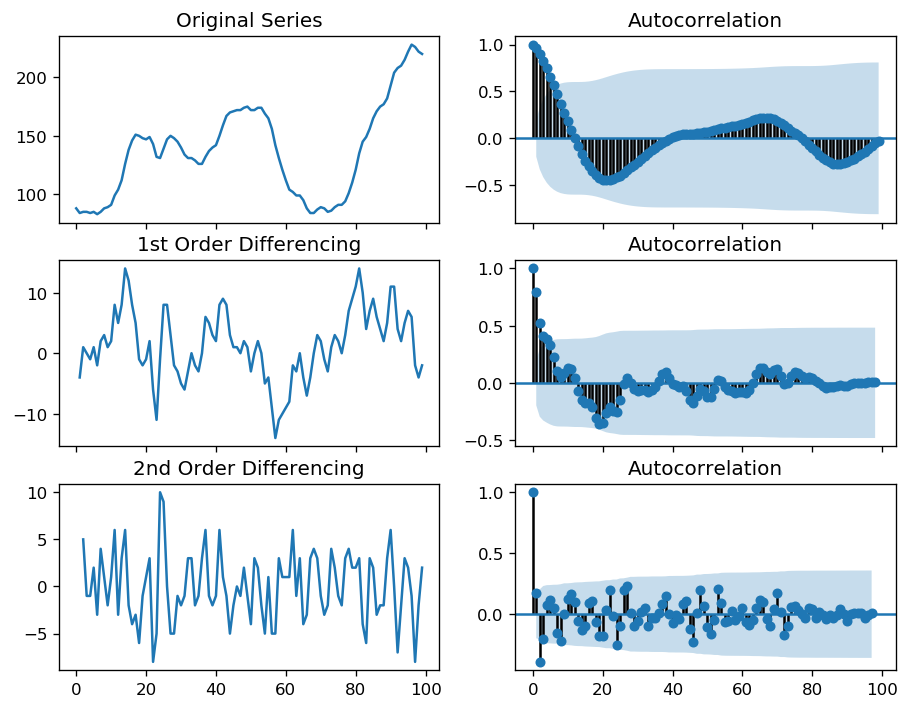

In [7]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

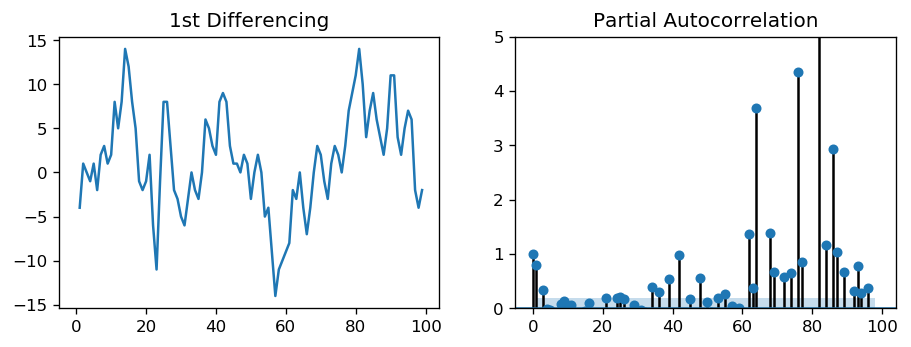

In [8]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()

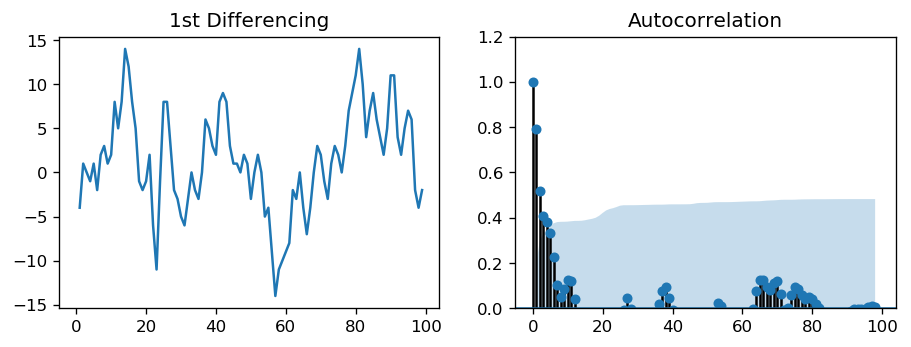

In [9]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

In [10]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df.value, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   99
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -253.790
Method:                       css-mle   S.D. of innovations              3.119
Date:                Mon, 11 Oct 2021   AIC                            517.579
Time:                        10:57:53   BIC                            530.555
Sample:                             1   HQIC                           522.829
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1202      1.290      0.868      0.387      -1.409       3.649
ar.L1.D.value     0.6351      0.257      2.469      0.015       0.131       1.139
ma.L1.D.value     0.5287      0.355     

Notice here the coefficient of the MA2 term is close to zero and the P-Value in ‘P>|z|’ column is highly insignificant. It should ideally be less than 0.05 for the respective X to be significant.

So, let’s rebuild the model without the MA2 term.

In [11]:
# 1,1,1 ARIMA Model
model = ARIMA(df.value, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   99
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -253.790
Method:                       css-mle   S.D. of innovations              3.119
Date:                Mon, 11 Oct 2021   AIC                            515.579
Time:                        10:57:53   BIC                            525.960
Sample:                             1   HQIC                           519.779
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1205      1.286      0.871      0.386      -1.400       3.641
ar.L1.D.value     0.6344      0.087      7.317      0.000       0.464       0.804
ma.L1.D.value     0.5297      0.089     

The model AIC has reduced, which is good. The P Values of the AR1 and MA1 terms have improved and are highly significant (<< 0.05).

Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).

In [12]:
residuals = pd.DataFrame(model_fit.resid)
residuals.rename(columns={0:'val'}, inplace=True)

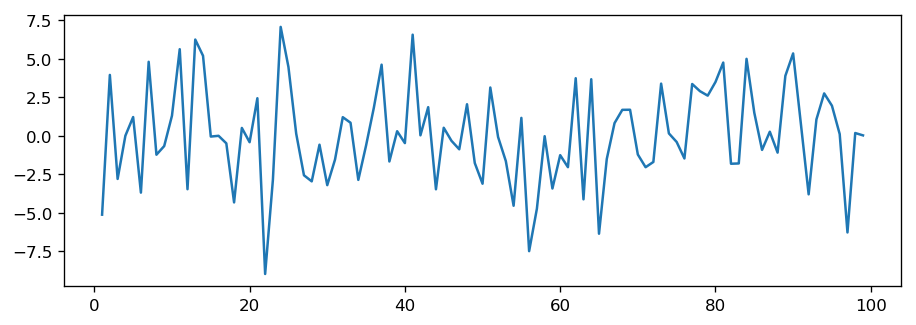

In [13]:
plt.plot(residuals.val)

In [14]:
import seaborn as sns

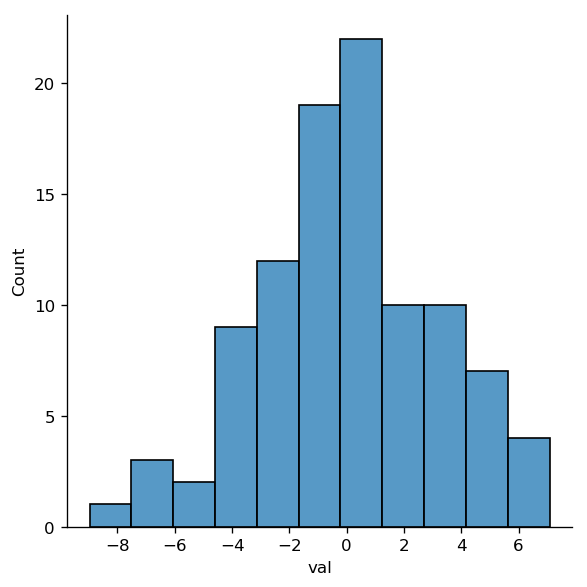

In [15]:
sns.displot(residuals.val)

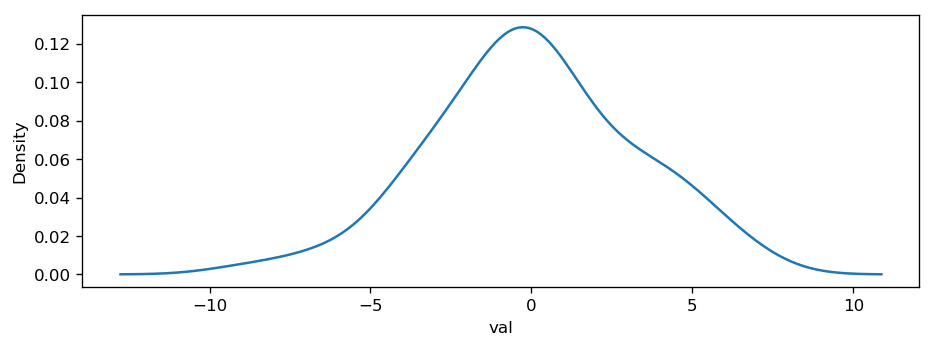

In [16]:
sns.kdeplot(residuals.val)

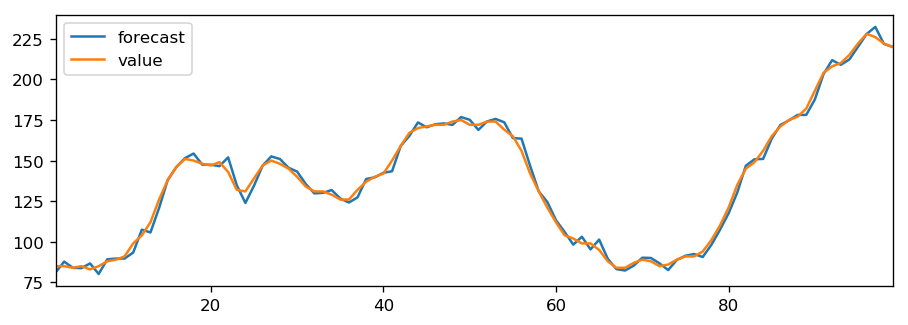

In [19]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [18]:
import numpy as np
print(np.__version__)

1.19.5


In [20]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df.value[:85]
test = df.value[85:]

In [21]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

In [22]:
# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

In [27]:
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

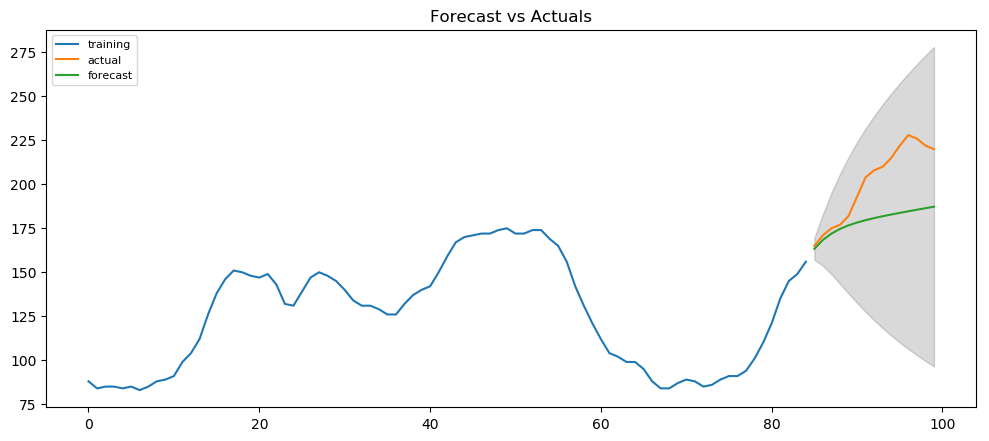

In [28]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   83
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -214.248
Method:                       css-mle   S.D. of innovations              3.153
Date:                Mon, 11 Oct 2021   AIC                            440.497
Time:                        13:39:09   BIC                            455.010
Sample:                             2   HQIC                           446.327
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0483      0.084      0.577      0.565      -0.116       0.212
ar.L1.D2.value     1.1386      0.109     10.399      0.000       0.924       1.353
ar.L2.D2.value    -0.5923      0.155

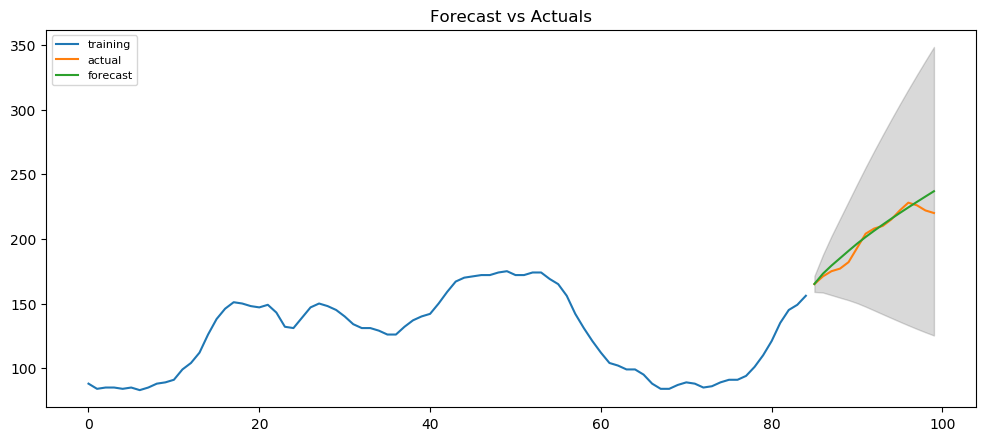

In [29]:
# Build Model
model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [30]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

#> {'mape': 0.02250131357314834,
#>  'me': 3.230783108990054,
#>  'mae': 4.548322194530069,
#>  'mpe': 0.016421001932706705,
#>  'rmse': 6.373238534601827,
#>  'acf1': 0.5105506325288692,
#>  'corr': 0.9674576513924394,
#>  'minmax': 0.02163154777672227}

{'mape': 0.022501373366352207,
 'me': 3.230816836823696,
 'mae': 4.5483344765989875,
 'mpe': 0.016421160180041246,
 'rmse': 6.373260481866188,
 'acf1': 0.5105500557416672,
 'corr': 0.9674576345452454,
 'minmax': 0.021631600767784587}